In [12]:
%load_ext autoreload
%autoreload 2

import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import birth_death_utils as bd
import os
from collections import Counter
from tqdm.notebook import tqdm
import pickle
from itertools import groupby
import pandas as pd
import yaml
import re
import multiprocessing as mp
import seaborn as sns

from sbi.analysis import pairplot
from sbi.inference import NPE, simulate_for_sbi, NLE
from sbi.utils import BoxUniform

from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

from torch import Tensor

# 1) Computation of summary statistics

In [19]:
def compute_summary_stats(g):
    """
    Generate a vector of summary statistics from a graph generated by birth-death simulation

    Parameters
    ----------
    g : nx.DiGraph()
        tree graph generated by birth_death_utils.ct_bd_tree
    
    Returns
    -------
    list
        vector of summary statistics characterizing a single tradition
    """
    n_living = list(nx.get_node_attributes(g, 'state').values()).count(True)

    if n_living == 0:
        return None

    if n_living > 0:
        birth_times_trad = []
        for n in g.nodes():
            if g.nodes[n]['state']:
                birth_times_trad.append(g.nodes[n]['birth_time'])
        timelapse = int(max(birth_times_trad)-min(birth_times_trad))
        earliest_wit = int(min(birth_times_trad))
        median_wit = int(np.median(birth_times_trad))
        latest_wit = int(max(birth_times_trad))
    
    if n_living == 1:
        return [1, timelapse, earliest_wit, median_wit, latest_wit, -1,-1,-1,-1,-1,-1,-1]

    if n_living == 2:
        
        return [2, timelapse, earliest_wit, median_wit, latest_wit, -1,-1,-1,-1,-1,-1,-1]
    
    if n_living >= 3:
        degrees = []
        direct_filiation_nb = 0
        arch_dists = []
        st = bd.generate_stemma(g)
        archetype = bd.root(st)

        for n in st.nodes():
            degrees.append(st.out_degree(n))

            if n != archetype:
                father = list(st.predecessors(n))[0]
                if st.nodes[n]['state'] and st.nodes[father]['state']:
                    direct_filiation_nb +=1
            if st.nodes[n]['state']:
                birth_times_trad.append(st.nodes[n]['birth_time'])
            arch_dists.append(len(nx.shortest_path(st, source=archetype, target=n)))
        
        deg_dist = Counter(degrees)
        deg1 = deg_dist[1]
        deg2 = deg_dist[2]
        deg3 = deg_dist[3]
        deg4 = deg_dist[4]
        depth = max(arch_dists)
        n_nodes = len(list(st.nodes()))

        return [
            n_living,
            timelapse,
            earliest_wit,
            median_wit,
            latest_wit,
            n_nodes,
            direct_filiation_nb,
            deg1,
            deg2,
            deg3,
            deg4,
            depth
        ]

In [37]:
g = bd.generate_tree_unified(0.006, 0.002, 1, 0, 1000, 1000, 500)
toto = compute_summary_stats(g)
toto

[1, 0, 661, 661, 661, -1, -1, -1, -1, -1, -1, -1]

# 2) Prepare empirical data

In this section we compute the summary statistics used for inference from the empirical data. These data are extracted from two different sources:
+ The OpenStemmata database
+ the table Old_French_witnesses for tradition consisting of less than 3 witnesses

these computation are essentially similar to those found in the analysis notebook

## a) From OpenStemmata

In [36]:
def convert_date(x):
    pattern1 = re.compile('[0-9][0-9][0-9][0-9]')
    pattern2 = re.compile('[0-9][0-9][0-9][0-9]-[0-9][0-9][0-9][0-9]')

    if bool(pattern1.fullmatch(x)):
        return int(x)
    if bool(pattern2.fullmatch(x)):
        xx = x.split('-')
        return (int(xx[0]),int(xx[1]))

def top(x):
    '''
    Upper bound on witness date (single year or range)
    '''
    match x:
        case (x1, x2):
            return x2
        case _:
            return x

def bottom(x):
    '''
    Lower bound on witness date (single year or range)
    '''
    match x:
        case (x1, x2):
            return x1
        case _:
            return x


def expected_abs_diff_degenerate(c, a, b):
    '''
    Returns the expectation value of the timelapse between one date given as range
    and one other as a single year
    '''
    if a == b:
        return abs(a - c)
    if a <= c <= b:
        return ((c-a)**2 + (b-c)**2) / (2*(b-a))
    elif c < a:
        return (a+b)/2 - c
    else: 
        return c - (a+b)/2

def expected_abs_diff(a, b, c, d):
    '''
    Return the expectation value of the timelapse between two dates given as
    intervals
    '''
    if a == b:
        return expected_abs_diff_degenerate(a, c, d)
    if c == d:
        return expected_abs_diff_degenerate(c, a, b)
    elif a < b < c < d:
        return (c+d-b-a)/2
    elif a <= c <= d < b:
        return (1/(b-a)) * ((1/2)*((d-a)*(c-a)+(b-d)*(b-c)) + (1/3)*(d-c)**2)
    elif a <= c <= b <= d:
        return (1/(b-a)) * ((1/2)* ((c-a)*(d-a) + (b-c)*(d-b)) + (1/(3*(d-c)))*(b-c)**3 )
    else:
        print(f"{a},{b} -- {c},{d} ")
        raise ValueError("Must have a < b, c < d, and a < c")

wholeCorpus = {}
corpus_dates = {}
corpus_workdates = {}

for work in os.listdir(f'corpus_stemmata/'):
    #print(f'{work}')
    st = bd.load_from_OpenStemmata(f'corpus_stemmata/{work}/stemma.gv')
    with open(f"corpus_stemmata/{work}/metadata.txt", 'r') as f:
        content = f.read()
    metadata = yaml.safe_load(content)
    if "wits" in metadata:
        dates = [wit["witOrigDate"] for wit in metadata['wits'] if wit["witOrigDate"] != '']
        missing_dates = [wit for wit in metadata['wits'] if wit["witOrigDate"] == '']
        if missing_dates != []:
            print(f"missing witnesses dates in {work}")
    else:
        print(f"no witnesses in {work}")
        dates = []

    if "workOrigDate" in metadata and metadata["workOrigDate"] != '':
        workDate = convert_date(metadata["workOrigDate"])

    else:
        print(f"missing work date in {work}")
        workDate = ''

    dates_num = []
    for x in dates:
        if x != '':
            date_num = convert_date(x)
            if date_num != None:
                dates_num.append(date_num)
 
    wholeCorpus[f"{work}"] = st
    corpus_dates[f"{work}"] = dates_num
    corpus_workdates[f"{work}"] = ''

ranges_per_work = {}
earliest_wit = {}
median_wit = {}
latest_wit = {}

for work, t_dates in corpus_dates.items():
    if t_dates != []:
        lb = sorted(t_dates, key=bottom)[0]
        ub = sorted(t_dates, key=top)[-1]
        ranges_per_work[work] = (lb,ub)
        if corpus_workdates[work] != '':
            for w,v in work, (corpus_workdates[work], lb):
                match v:
                    case [(a,b), (c,d)]:
                        earliest_wit[w] = expected_abs_diff(a,b,c,d)
                    case [(a,b), c]:
                        earliest_wit[w] = expected_abs_diff_degenerate(a,b,c)
                    case [c,(a,b)]:
                        earliest_wit[w] = expected_abs_diff_degenerate(a,b,c)
                    case [a,b]:
                        earliest_wit[w] = abs(a-b)
                    case _:
                        print('error')
            for w,v in work, (corpus_workdates[work], ub):
                match v:
                    case [(a,b), (c,d)]:
                        latest_wit[w] = expected_abs_diff(a,b,c,d)
                    case [(a,b), c]:
                        latest_wit[w] = expected_abs_diff_degenerate(a,b,c)
                    case [c,(a,b)]:
                        latest_wit[w] = expected_abs_diff_degenerate(a,b,c)
                    case [a,b]:
                        latest_wit[w] = abs(a-b)
                    case _:
                        print('error')

            median_wit = np.median(corpus_workdates[work])        


lifespans = {}
for w,v in ranges_per_work.items():
    match v:
        case [(a,b), (c,d)]:
            lifespans[w] = expected_abs_diff(a,b,c,d)
        case [(a,b), c]:
            lifespans[w] = expected_abs_diff_degenerate(a,b,c)
        case [c,(a,b)]:
            lifespans[w] = expected_abs_diff_degenerate(a,b,c)
        case [a,b]:
            lifespans[w] = abs(a-b)
        case _:
            print('error')

x_obs0 = {}
sizes = {}
for k in lifespans.keys():
    ## computation of observables
    g = wholeCorpus[k]

    n_living = list(nx.get_node_attributes(g, 'state').values()).count(True)
    sizes[k] = n_living
    degrees = []
    direct_filiation_nb = 0
    arch_dists = []

    if n_living >= 3:
        st = bd.generate_stemma(g)
        archetype = bd.root(st)
        for n in st.nodes():
            degrees.append(st.out_degree(n))

            if n != archetype:
                father = list(st.predecessors(n))[0]
                if st.nodes[n]['state'] and st.nodes[father]['state']:
                    direct_filiation_nb +=1
            arch_dists.append(len(nx.shortest_path(st, source=archetype, target=n)))
        
        timelapse = lifespans[k]
        deg_dist = Counter(degrees)
        deg1 = deg_dist[1]
        deg2 = deg_dist[2]
        deg3 = deg_dist[3]
        deg4 = deg_dist[4]
        depth = max(arch_dists)
        n_nodes = len(list(st.nodes()))

        x_obs0[k] = [
            n_living,
            4*int(timelapse),
            4*int(earliest_wit),
            4*int(median_wit),
            4*int(latest_wit),
            n_nodes,
            direct_filiation_nb,
            deg1,
            deg2,
            deg3,
            deg4,
            depth
        ]

missing witnesses dates in Ponceau_1997c_SaintGraal
missing witnesses dates in Ruelle_1960_HuonBordeaux
no witnesses in Cloetta_1911_Moniage1
missing work date in Cloetta_1911_Moniage1
missing witnesses dates in Stimming_1920_BeuveHanstCont3-3
no witnesses in Herbin_2018a_Anseys
missing witnesses dates in Treutler_1880_Otinel
no witnesses in Gregory_1993_Cliges
missing witnesses dates in Pope_1955_Thomas-Horn
missing witnesses dates in Lagomarsini_2018_GuironCourtois1
missing witnesses dates in Tyssens_1967_CourLouis
no witnesses in Jonin_1958_Yvain
missing witnesses dates in Korte_1914_RenMont6
missing witnesses dates in Ponceau_1997a_SaintGraal
missing witnesses dates in Rolin_1897_Aliscans2-Rainouart
missing work date in Rolin_1897_Aliscans2-Rainouart
missing witnesses dates in Bedier_1902_Tristan
missing work date in Bedier_1902_Tristan
missing witnesses dates in Bogdanow_1991_MortArtuPV
no witnesses in Veneziale_2020_Guiron-Cont
missing witnesses dates in Braunholtz_1921_Horn
no w

In [30]:
x_obs0

{'Rochebouet_2021_RTroieProse5-2': [17, 852, 31, 1, 1, 13, 1, 0, 10],
 'Tyssens_1967_CharroiNimes': [8, 448, 13, 0, 0, 3, 2, 0, 5],
 'Eusebi_1963_ChevOgierDanemarche': [5, 640, 9, 0, 0, 4, 0, 0, 4],
 'Tyssens_1967_PriseOrange': [9, 300, 15, 0, 0, 4, 2, 0, 5],
 'Alton_1889_MarquesRome': [10, 752, 14, 3, 3, 5, 0, 0, 5],
 'Karsch_1907_Gaydon': [3, 1200, 5, 0, 0, 2, 0, 0, 3],
 'Ponceau_1997c_SaintGraal': [14, 1440, 22, 0, 0, 6, 0, 1, 5],
 'Ruelle_1960_HuonBordeaux': [3, 720, 5, 0, 0, 2, 0, 0, 3],
 'Blanchard_1976_TristanProseV1': [7, 668, 12, 1, 1, 5, 0, 0, 5],
 'Stimming_1920_BeuveHanstCont3-3': [5, 492, 9, 0, 0, 4, 0, 0, 4],
 'Tyssens_1967_MoniageRainouart2': [10, 448, 17, 0, 0, 5, 2, 0, 6],
 'Latour_1976_GuiBourgogne1': [3, 400, 5, 0, 0, 2, 0, 0, 3],
 'Tyssens_1967_ChevVivien': [9, 460, 16, 0, 0, 6, 1, 0, 7],
 'Thorpe_1992_Jerusalem': [10, 444, 17, 0, 0, 5, 2, 0, 7],
 'Sweetser_1964_Blancandin': [5, 200, 8, 0, 0, 2, 1, 0, 4],
 'LeonardiTrachsler_2021_Meliadus1': [17, 900, 29, 0, 0, 10, 

## b) For texts without stemmata (with 1 or 2 witnesses)

In [16]:
df = pd.read_csv("Old_French_witnesses.csv")
f2_works = []
f1_works = []
works = set(list(df['text H-ID']))
size_frags_d = []
size_d = []
for work in works:
    n_wit = len(df[(df['text H-ID'] == work) & (df['status'] != 'fragment')])
    n_frags = len(df[(df['text H-ID'] == work) & (df['status'] == 'fragment')])
    if n_wit !=0:
        size_d.append(n_wit)
    if n_frags !=0:
        size_frags_d.append(n_frags)

    if n_wit == 2:
        f2_works.append(work)
    if n_wit == 1:
        f1_works.append(work)

size_dist = Counter(size_d)
size_dist_frags = Counter(size_frags_d)

In [17]:
f2_dates_0 = [df[(df["text H-ID"] == x) & (df['status'] != 'fragment')]["Date"].values.tolist() for x in f2_works]
f2_dates = [list(map(convert_date, x)) for  x in f2_dates_0]

ranges_per_work = []
for t_dates in f2_dates:
    if t_dates != []:
        lb = sorted(t_dates, key=bottom)[0]
        ub = sorted(t_dates, key=top)[-1]
        ranges_per_work.append((lb,ub))


lifespans_f2 = []
for v in ranges_per_work:
    match v:
        case [(a,b), (c,d)]:
            lifespans_f2.append(expected_abs_diff(a,b,c,d))
        case [(a,b), c]:
            lifespans_f2.append(expected_abs_diff_degenerate(a,b,c))
        case [c,(a,b)]:
            lifespans_f2.append(expected_abs_diff_degenerate(a,b,c))
        case [a,b]:
            lifespans_f2.append(abs(a-b))
        case _:
            print('error')

The summary statistics extracted from our two database are gathered and shuffled in a list ```x_obs_empirical``` of feature-vectors. The numbers of vectors corresponding to traditions with 1 or 2 witnesses added to the OpenStemmata is chosen so as to ensure that the median and relative proportions of tradition sizes for small tradition are the same as in the larger data corpus (contained in ```Old_French_witnesses.csv```)

In [18]:
add_f1 = [[
        1,
        0,
        -1,
        -1,
        -1,
        -1,
        -1,
        -1,
        -1] for k in range(61)]

add_f2 = [[2, int(4 * n), -1,-1,-1,-1,-1,-1,-1] for n in lifespans_f2]
x_obs_empirical = list(x_obs0.values()) + add_f1 + add_f2[:17]

random.shuffle(x_obs_empirical)

# 3) Simulation based inference --Training Neural Likelihood Estimator

In this section we perform the parameter inference using Simulation Based inference and more specifically the Neural Likelihood method as implemented in the ```sbi``` package. We take a uniform prior on a box ```[lambda_minx_prior, lambda_max_prior] * [mu_min_prior, mu_max_prior]```, and generate ```N_samples_prior``` simulations for each setting of the model.

*Note that pre-trained inference models are available in the ```inference_models``` folder*

In [42]:
lambda_min_prior = 4.*10**(-3)
lambda_max_prior = 9.*10**(-3)

mu_min_prior = 1.*10**(-3)
mu_max_prior = 5*10**(-3)

decay_min_prior = 0
decay_max_prior = 1

decimation_min_prior = 0
decimation_max_prior = 1

N_samples_prior = 100#500_000 #500000
N_samples_posterior = 10 #1000

## a) Joint model training

In [43]:
def simulator(theta):
    lda0, mu, decay, decim = theta
    g = bd.generate_tree_unified(lda0, mu, decay, decim, 1000, 1000, 500)

    return g    

prior = BoxUniform(low=Tensor([lambda_min_prior, mu_min_prior, decay_min_prior, decimation_min_prior]), 
                          high=Tensor([lambda_max_prior, mu_max_prior, decay_max_prior, decimation_max_prior]))


In [44]:
theta0 = prior.sample((N_samples_prior,))

theta  = []
x = []

for t in tqdm(theta0):
    vec = compute_summary_stats(simulator(t))
    if vec != None:
        theta.append(list(t))
        x.append(vec)

  0%|          | 0/100 [00:00<?, ?it/s]

In [45]:
inference = NLE(prior=prior)
inference = inference.append_simulations(Tensor(theta), Tensor(x))
likelihood_estimator = inference.train()
#with open("pretrained_models/inference_unif.pickle", "wb") as f:
#    pickle.dump(inference, f)

 Neural network successfully converged after 100 epochs.

In [ ]:
#load pretrained model serialized as pickle object
#with open("pretrained_models/inference_unif.pickle", "rb") as f:
#    inference = pickle.load(f)

In [31]:
#posterior = inference.build_posterior(sample_with="rejection")
posterior = inference.build_posterior()

/home/jbcamps/Data/F/Articles_et_CR/2022_Article_Silva_portentosa/ExtinctionOfTexts/env/lib/python3.12/site-packages/sbi/inference/posteriors/mcmc_posterior.py:126: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


In [ ]:
samples = posterior.sample(
    (N_samples_posterior,),
    x=x_obs_empirical
)

Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
_ = pairplot(
    samples,
    limits=[[lambda_min_prior, lambda_max_prior], [mu_min_prior, mu_max_prior], [decay_min_prior, decay_max_prior], [decimation_min_prior, decimation_max_prior]],
    figsize=(5, 5),
    labels=[r"$\lambda$", r"$\mu$", r"decay", r"decimation"]
)

/tmp/ipykernel_112805/245841850.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_samples['model'], hist=True, kde=True,


<Axes: xlabel='model', ylabel='Density'>

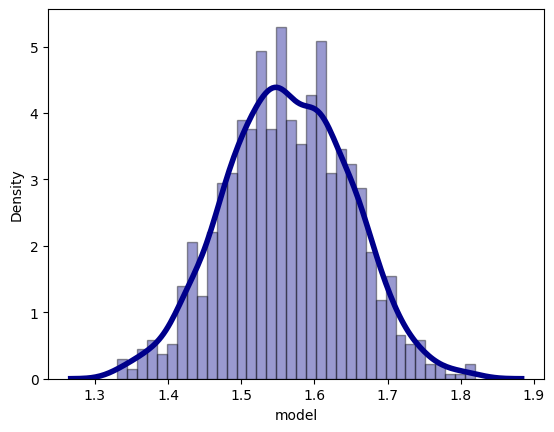

In [26]:
df_samples = pd.DataFrame({'lambda':[x[0] for x in samples.tolist()], 'mu':[x[1] for x in samples.tolist()], 'model':[x[2] for x in samples.tolist()]})
#sns.kdeplot(data=df_samples, x='lambda', y='mu', fill=True)
#sns.kdeplot(data=df_samples, x='lambda', y='model', fill=True)
sns.distplot(df_samples['model'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

## Looking at loss during training for different models

In [7]:
from sbi.analysis import plot_summary
import pickle
import matplotlib.pyplot as plt

# Load the pickled neural networks
likelihood_estimators = []
for filename in ["inference_unif.pickle", "inference_unif_server.pickle", "inference_unif_run3.pickle"]:
    with open("pretrained_models/"+filename, "rb") as f:
        inference = pickle.load(f)
    print(inference.keys())
    #plot_summary(inference)


AttributeError: 'NLE_A' object has no attribute 'keys'

In [9]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import os

# Directory containing the logs
log_dir = "sbi-logs/NLE_A"

# Iterate over each log directory
for i, log_subdir in enumerate(os.listdir(log_dir)):
    log_path = os.path.join(log_dir, log_subdir)

    # Load the event accumulator
    event_acc = EventAccumulator(log_path)
    event_acc.Reload()

    # Extract the tags (e.g., 'training_loss', 'validation_loss')
    tags = event_acc.Tags()['scalars']

    # Plot each tag
    for tag in tags:
        events = event_acc.Scalars(tag)

        # Extract the steps and values
        steps = [e.step for e in events]
        values = [e.value for e in events]

        # Plot
        plt.figure()
        plt.plot(steps, values, label=tag)
        plt.xlabel('Step')
        plt.ylabel(tag)
        plt.title(f'{tag} for Model {i+1}')
        plt.legend()
        plt.savefig(f'{tag}_model_{i+1}.pdf', dpi=300, bbox_inches='tight')
        plt.close()

## b) Model checks
Here, we simulate traditions for each model, and look at the model ability to distinguish them.

In [29]:
def p_m_given_x_lambda_mu(x_obs, lam, mu):
    x_obs = torch.as_tensor(x_obs, dtype=torch.float32)

    # Ensure (num_trials, x_dim)
    if x_obs.ndim == 1:
        x_obs = x_obs.unsqueeze(0)

    # Expand to (num_trials, batch=3, x_dim)
    x_obs = x_obs.unsqueeze(1).repeat(1, 3, 1)

    theta = torch.tensor(
        [
            [lam, mu, 0.0],
            [lam, mu, 1.0],
            [lam, mu, 2.0],
        ],
        dtype=torch.float32,
    )

    with torch.no_grad():
        log_lik = likelihood_estimator.log_prob(x_obs, theta)

    return torch.softmax(log_lik, dim=1).squeeze(0)
    
lam_star = 0.006
mu_star = 0.0025

for true_m in [0, 1, 2]:
    theta_test = torch.tensor([lam_star, mu_star, float(true_m)])

    x_test = None
    while x_test is None:
        x_test = compute_summary_stats(simulator(theta_test))

    probs = p_m_given_x_lambda_mu(x_test, lam_star, mu_star)

    print("True m:", true_m)
    print("p(m | x, λ, μ):", probs)

True m: 0
p(m | x, λ, μ): tensor([0.2270, 0.3167, 0.4563])
True m: 1
p(m | x, λ, μ): tensor([0.2663, 0.3548, 0.3789])
True m: 2
p(m | x, λ, μ): tensor([0.2270, 0.3167, 0.4563])


### Model evidence

In [37]:
def compute_model_evidence(likelihood_estimator, prior_params, x_obs, model_index, n_samples=10000):
    """
    Approximate the model evidence for a given model and observed data.

    Args:
        likelihood_estimator: Trained density estimator (e.g., NLE)
        prior_params: Prior distribution for the parameters (lambda, mu)
        x_obs: Observed data (summary statistics)
        model_index: Integer (0, 1, or 2) for the model of interest
        n_samples: Number of samples for Monte Carlo integration

    Returns:
        Approximate log model evidence
    """

    x_obs = torch.tensor(x_obs, dtype=torch.float32) if not isinstance(x_obs, torch.Tensor) else x_obs
    
    # Sample parameters (lambda, mu) from the prior
    theta_samples = prior_params.sample((n_samples,))

    # Append the model index to each sample
    theta_samples_with_model = torch.cat([
        theta_samples,
        torch.full((n_samples, 1), model_index, dtype=torch.float32)
    ], dim=1)

    # Evaluate the log likelihood for each sample
    log_likelihoods = likelihood_estimator.log_prob(x_obs, theta_samples_with_model)

    # Evaluate the log prior for each sample
    log_priors = prior_params.log_prob(theta_samples)

    # Compute the log joint probability
    log_joint = log_likelihoods + log_priors

    # Approximate the log evidence using logsumexp for numerical stability
    log_evidence = torch.logsumexp(log_joint, dim=0) - torch.log(torch.tensor(n_samples))

    return log_evidence

# For each model, compute the evidence
log_evidence_model_0 = compute_model_evidence(likelihood_estimator, prior_params, x_obs, model_index=0)
log_evidence_model_1 = compute_model_evidence(likelihood_estimator, prior_params, x_obs, model_index=1)
log_evidence_model_2 = compute_model_evidence(likelihood_estimator, prior_params, x_obs, model_index=2)

# Compare the model evidences (higher is better)
print("Model 0 evidence:", log_evidence_model_0)
print("Model 1 evidence:", log_evidence_model_1)
print("Model 2 evidence:", log_evidence_model_2)

AssertionError: Batch shape of condition 10000 and input 9 do not match.

In [46]:
len(x_base)

360

### Base

In [45]:
theta0_base = prior.sample((1000,))

theta_base  = []
x_base = []

for t in tqdm(theta0_base):
    vec = compute_summary_stats(simulator_base(t))
    if vec != None:
        theta_base.append(list(t))
        x_base.append(vec)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
samples_base = posterior.sample((N_samples_posterior,), x=x_base)

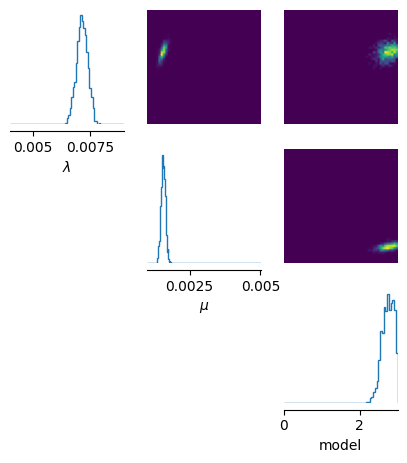

In [34]:
_ = pairplot(
    samples_base,
    limits=[[lambda_min_prior, lambda_max_prior], [mu_min_prior, mu_max_prior], [0,3]],
    figsize=(5, 5),
    labels=[r"$\lambda$", r"$\mu$", r"model"]
)

In [ ]:
df_samples_base = pd.DataFrame({'lambda':[x[0] for x in samples_base.tolist()], 'mu':[x[1] for x in samples_base.tolist()], 'model':[x[2] for x in samples_base.tolist()]})
sns.distplot(df_samples_base['model'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

### Decay

In [11]:
#with open("pretrained_models/inference_joint.pickle", "rb") as f:
#    inference = pickle.load(f)
#posterior = inference.build_posterior(sample_with="rejection")
#likelihood_estimator = inference.train()

 Neural network successfully converged after 68 epochs.

In [10]:
theta0_decay = prior.sample((10_000,))

theta_decay  = []
x_decay = []

for t in tqdm(theta0_decay):
    vec = compute_summary_stats(simulator_decay(t))
    if vec != None:
        theta_decay.append(list(t))
        x_decay.append(vec)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
samples_decay = posterior.sample((N_samples_posterior,), x=x_decay)

In [ ]:
_ = pairplot(
    samples_decay,
    limits=[[lambda_min_prior, lambda_max_prior], [mu_min_prior, mu_max_prior], [0,3]],
    figsize=(5, 5),
    labels=[r"$\lambda$", r"$\mu$", r"model"]
)

In [ ]:
df_samples_decay = pd.DataFrame({'lambda':[x[0] for x in samples_decay.tolist()], 'mu':[x[1] for x in samples_decay.tolist()], 'model':[x[2] for x in samples_decay.tolist()]})
sns.distplot(df_samples_decay['model'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

### Decimation

In [31]:
theta0_decim = prior.sample((10_000,))

theta_decim  = []
x_decim = []

for t in tqdm(theta0_decim):
    vec = compute_summary_stats(simulator_decim(t))
    if vec != None:
        theta_decim.append(list(t))
        x_decim.append(vec)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
samples_decim = posterior.sample((N_samples_posterior,), x=x_decim)

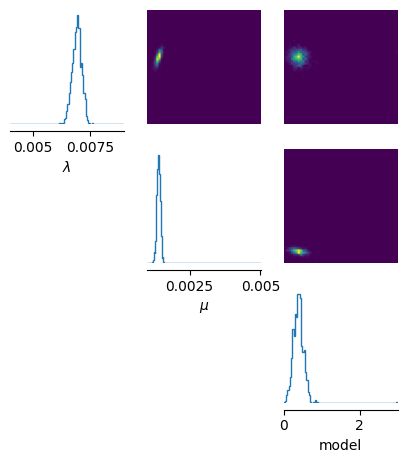

In [29]:
_ = pairplot(
    samples_decim,
    limits=[[lambda_min_prior, lambda_max_prior], [mu_min_prior, mu_max_prior], [0,3]],
    figsize=(5, 5),
    labels=[r"$\lambda$", r"$\mu$", r"model"]
)

/tmp/ipykernel_112805/1195207057.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_samples_decim['model'], hist=True, kde=True,


<Axes: xlabel='model', ylabel='Density'>

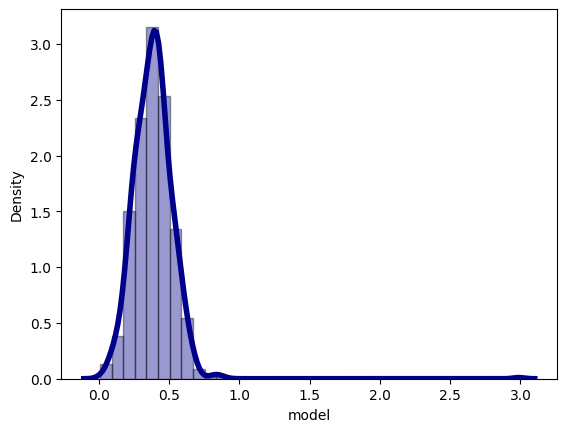

In [30]:
df_samples_decim = pd.DataFrame({'lambda':[x[0] for x in samples_decim.tolist()], 'mu':[x[1] for x in samples_decim.tolist()], 'model':[x[2] for x in samples_decim.tolist()]})
sns.distplot(df_samples_decim['model'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})